# Project: ICD-AIS conversion using Deep Learning

This script examines the attention matrix of the model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import icd9cms
import icd10
import math

## Load data

In [3]:
# load attention file
attn_file = "../Results/test_ais_pred_early_stop-100-attn.csv"
#attn_file = "../Results/train_ais_pred_early_stop-100-attn.csv"
#attn_file = "../Results/test_ais_pred_early_stop-d_only-100-attn.csv"

with open(attn_file) as f:
    lines = f.readlines()

In [4]:
# load actual AIS codes
ais_file = "../Data/test_ais_pre_I9_A05.csv"
#ais_file = "../Data/train_ais_pre_I9_A05.csv"

ais = pd.read_csv(ais_file, header=None).rename(columns={0:'AIS_actual'})

In [5]:
# load AIS codes
ais_lu_file = "../Data/AIS08_codes.csv"

# load AIS codes
ais_lu = pd.read_csv(ais_lu_file, header=0, encoding='iso-8859-1')

# get predot code
ais_lu['predot'] = ais_lu.code.apply(lambda x: math.floor(x))

# make dictionary of codes
ais_dot = pd.Series(ais_lu.code.values, index=ais_lu.predot).to_dict()
ais_dot[0] = 0.0
ais_dot[-1] = -1.0

## Parse file

In [6]:
# remove first two lines
lines = lines[3:]

In [7]:
attn_mat = []

for i,l in enumerate(lines):
    #print(i,l)
    
    # check if new attention matrix
    if l.startswith("[2022"):
        
        # remove timestamp and newline
        #l = l[l.find('D'):]
        l = l[l.find('A'):]
        l = l[:l.find('\\')]
        
        # get icd codes
        icd_codes = list(filter(None, l.split(" ")))
        
        # create data frame
        attn_df = pd.DataFrame(columns=['AIS']+icd_codes)
    
    # else this is not a new matrix
    else:
        # check if not empty line
        if l[0]!='\n':
            # get AIS code and attention weights
            ais_codes = list(filter(None, l.split(" ")))

            # remove asterisk
            ais_codes = [s.replace('*','') for s in ais_codes]

            # remove newline
            ais_codes = ais_codes[:len(ais_codes)-1]
            
            # convert weights to floats
            ais_codes = [ais_codes[0]] + [float(x) for x in ais_codes[1:len(ais_codes)]]
            
            # append to df
            attn_df.loc[len(attn_df)] = ais_codes
        
        # end of matrix, store
        else:
            #display(attn_df)
            
            attn_mat.append(attn_df)

In [8]:
icd_codes

['AVG', 'SCORE:', '-0.7922,', 'PRED', 'PPL:', '2.2082']

In [9]:
ais_codes

['</s>',
 0.1271546,
 0.1391219,
 0.1410825,
 0.1386032,
 0.1353844,
 0.1250679,
 0.0606395,
 0.0600177,
 0.0729281]

In [10]:
l

'AVG SCORE: -0.7922, PRED PPL: 2.2082'

## Function to display attention matrix

In [11]:
def display_attn(attn_df, showmat=True, colorbar=True, d_only=False):
    '''
    This function displays attention weights for translations.
    Parameters:
        showmat - print attention dataframe
        attn_df - dataframe with attention weights
        colorbar - whether to add colorbar
    Returns:
        None - outputs matrix and plots
    '''
    
    # display matrix as dataframe
    if showmat:
        display(attn_df)
    
    # remove all non-D-codes if applicable
    if d_only:
        d_cols = [x for x in attn_df.columns  if x.startswith('D')]
        
        attn_df = attn_df[['AIS']+d_cols]
        
    # get weights
    weights = attn_df.iloc[:,1:].values

    # get icd and ais codes
    icd_codes = attn_df.columns[1:]
    ais_codes = attn_df.AIS.values      
    
    # display matrix
    plt.matshow(weights, cmap=plt.get_cmap('gray'))

    # add labels
    plt.xticks(np.arange(0, len(icd_codes), 1), icd_codes)
    plt.yticks(np.arange(0, len(ais_codes), 1), ais_codes)
    
    # add color bar if applicable
    if colorbar:
        plt.colorbar()
        
    plt.show()

## Decoding functions

In [12]:
def icd_to_text(icd_list, icd_version=9):
    '''
    This script takes a list of ICD codes and returns the text diagnoses.
    Parameters:
        icd_list - ICD codes to translate
    Returns:
        list of text diagnoses
    '''
    
    # list for text
    icd_txt = []
    
    # loop through all codes
    for code in icd_list:
        
        # check version of ICD
        if icd_version==9:
            
            # remove prefix from non-E/P codes
            if (code[0] == 'E') or (code[0] == 'P'):
                
                icd_trans = icd9cms.search(code)
            else:
                
                icd_trans = icd9cms.search(code[1:])
            
            # check if not valid code
            if icd_trans == None:
                
                icd_txt.append(code + ': code not found')
                
            else:
                
                # if no long description use short description
                if icd_trans.long_desc == None:
                    
                    icd_txt.append(code + ": " + icd_trans.short_desc)
                    
                else:
                    icd_txt.append(code + ": " + icd_trans.long_desc)
    
    return icd_txt

In [13]:
def icd_mat(mat, icd_version=9):
    
    icd_codes = mat.columns[1:]
    
    print(icd_codes)
    
    return icd_to_text(icd_codes)

In [14]:
icd_mat(attn_mat[0])

Index(['A79', 'E880.9', 'P87.03', 'P87.44', 'D850.0'], dtype='object')


['A79: code not found',
 'E880.9: Accidental fall on or from other stairs or steps',
 'P87.03: code not found',
 'P87.44: code not found',
 'D850.0: Concussion with no loss of consciousness']

In [15]:
def ais_to_text(ais_list, ais_version='2005'):
    '''
    This script takes a list of AIS codes and returns the text diagnoses.
    Parameters:
       ais_list - AIS codes to translate
    Returns:
        list of text diagnoses
    '''
    
    # list for text
    ais_txt = []
    
    # loop through all codes
    for code in ais_list:    

        if code != '</s>':
            
            # convert code to number
            code = int(code)
        
            if ais_version=='2005':
            
                if code in ais_lu.predot.values:
                
                    ais_txt.append(str(code) + ": " + ais_lu[ais_lu.predot==code].Description.values[0])
                
                else:
                
                    ais_txt.append(str(code) + ": code not found")
                
    return ais_txt

In [16]:
def ais_split(ais_str, ais_version='2005'):

    ais_split = ais_str.values[0].split(" ")

    ais_num = [int(x) for x in ais_split]

    return ais_to_text(ais_num)

In [17]:
attn_mat[0]

,AIS,A79,E880.9,P87.03,P87.44,D850.0
0,161001,0.225491,0.248663,0.232821,0.238867,0.054158
1,</s>,0.244717,0.227772,0.220282,0.209790,0.097438


## Visualization of Attention

,AIS,A73,E816.0,P87.03,P87.04,P87.41,P88.01,P88.38,P88.76,D811.02,D852.02,D873.1
0,110604,0.092528,0.119917,0.109110,0.092675,0.093355,0.097251,0.119935,0.240408,0.027571,0.005277,0.001972
1,140694,0.128362,0.132512,0.120473,0.097444,0.108797,0.111909,0.113782,0.131133,0.043813,0.005875,0.005901
2,750951,0.110974,0.128694,0.114371,0.110246,0.105610,0.106264,0.113274,0.145717,0.044379,0.013423,0.007048
3,</s>,0.120796,0.118136,0.112890,0.100302,0.111275,0.112543,0.105012,0.079718,0.063600,0.046245,0.029484


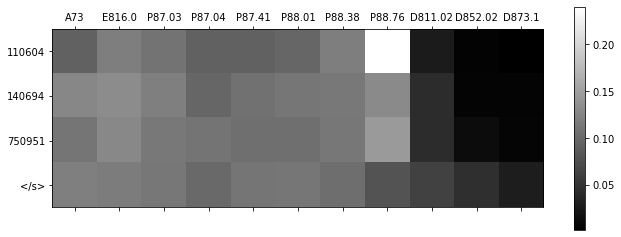

Actual ICD:
Index(['A73', 'E816.0', 'P87.03', 'P87.04', 'P87.41', 'P88.01', 'P88.38',
       'P88.76', 'D811.02', 'D852.02', 'D873.1'],
      dtype='object')


['A73: code not found',
 'E816.0: Motor vehicle traffic accident due to loss of control, without collision on the highway, injuring driver of motor vehicle other than motorcycle',
 'P87.03: code not found',
 'P87.04: code not found',
 'P87.41: code not found',
 'P88.01: code not found',
 'P88.38: code not found',
 'P88.76: code not found',
 'D811.02: Closed fracture of coracoid process of scapula',
 'D852.02: Subarachnoid hemorrhage following injury without mention of open intracranial wound, with brief [less than one hour] loss of consciousness',
 'D873.1: Open wound of scalp, complicated']

Predicted AIS:
2022-06-20 15:35:00,541: Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-06-20 15:35:00,543: NumExpr defaulting to 8 threads.


['110604: Scalp, laceration, major; >10cm long and into subcutaneous tissue',
 '140694: Cerebrum [includes basal ganglia, thalamus, putamen, globus pallidus], subarachnoid hemorrhage, not associated with coma >6 hours',
 '750951: Scapula fracture, body']

Actual AIS:


['110604: Scalp, laceration, major; >10cm long and into subcutaneous tissue',
 '140694: Cerebrum [includes basal ganglia, thalamus, putamen, globus pallidus], subarachnoid hemorrhage, not associated with coma >6 hours',
 '750961: Scapula fracture, neck with or without body']

In [18]:
i=9
display_attn(attn_mat[i])
print("Actual ICD:")
display(icd_mat(attn_mat[i]))
print("Predicted AIS:")
display(ais_to_text(attn_mat[i].AIS.values))
print("Actual AIS:")
display(ais_split(ais.iloc[i]))

,AIS,A56,E881.0,P88.01,P88.38,D805.4,D823.01,D825.20
0,650620,0.167682,0.222366,0.195501,0.198129,0.109517,0.062476,0.044330
1,852004,0.169064,0.242405,0.212674,0.218114,0.077985,0.050904,0.028854
2,854471,0.195999,0.222185,0.201282,0.194855,0.091479,0.051200,0.043000
3,</s>,0.182130,0.195848,0.180793,0.155171,0.109582,0.083505,0.092972


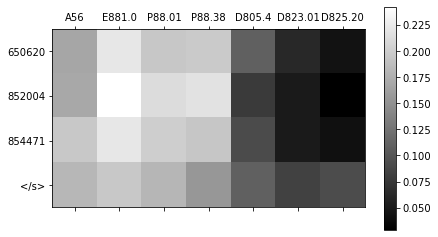

AIS_actual    650616 854441 857200
Name: 3, dtype: object


In [19]:
i=3
display_attn(attn_mat[i])
print(ais.iloc[i])

,AIS,A70,E885.9,P79.35,P87.03,D820.21
0,853151,0.211171,0.251925,0.230469,0.225884,0.080551
1,</s>,0.249452,0.219673,0.166636,0.192846,0.171391


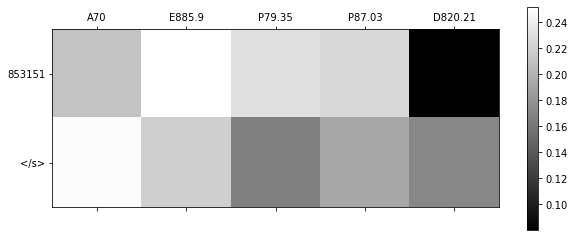

AIS_actual    853151
Name: 2, dtype: object


In [20]:
i=2
display_attn(attn_mat[i])
print(ais.iloc[i])

,AIS,A66,E812.0,P87.03,P87.41,P88.01,P88.38,P96.04,P96.71,D802.1,D805.05,D807.01,D861.21,D873.20
0,210602,0.102987,0.118329,0.100349,0.096298,0.094247,0.098671,0.088759,0.087482,0.100628,0.058636,0.030333,0.015449,0.007833
1,251002,0.074595,0.070437,0.060187,0.058491,0.057332,0.060331,0.045439,0.042993,0.299486,0.147280,0.047252,0.025534,0.010644
2,441407,0.133435,0.128659,0.106146,0.102081,0.099971,0.102860,0.079623,0.076343,0.076202,0.050963,0.023401,0.012649,0.007666
3,450201,0.111999,0.123212,0.112972,0.112765,0.111556,0.118961,0.099027,0.096950,0.037831,0.030132,0.022291,0.012481,0.009823
4,650220,0.122456,0.129550,0.109177,0.105158,0.103772,0.096761,0.090670,0.087208,0.063125,0.041353,0.023779,0.016400,0.010591
5,</s>,0.131393,0.142641,0.122625,0.118509,0.116107,0.105040,0.094134,0.089917,0.024047,0.019017,0.017012,0.010288,0.009270


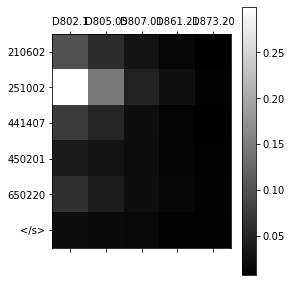

In [21]:
display_attn(attn_mat[17], d_only = True)

,AIS,A66,E812.0,P87.03,P87.41,P88.01,P88.38,P96.04,P96.71,D802.1,D805.05,D807.01,D861.21,D873.20
0,210602,0.102987,0.118329,0.100349,0.096298,0.094247,0.098671,0.088759,0.087482,0.100628,0.058636,0.030333,0.015449,0.007833
1,251002,0.074595,0.070437,0.060187,0.058491,0.057332,0.060331,0.045439,0.042993,0.299486,0.147280,0.047252,0.025534,0.010644
2,441407,0.133435,0.128659,0.106146,0.102081,0.099971,0.102860,0.079623,0.076343,0.076202,0.050963,0.023401,0.012649,0.007666
3,450201,0.111999,0.123212,0.112972,0.112765,0.111556,0.118961,0.099027,0.096950,0.037831,0.030132,0.022291,0.012481,0.009823
4,650220,0.122456,0.129550,0.109177,0.105158,0.103772,0.096761,0.090670,0.087208,0.063125,0.041353,0.023779,0.016400,0.010591
5,</s>,0.131393,0.142641,0.122625,0.118509,0.116107,0.105040,0.094134,0.089917,0.024047,0.019017,0.017012,0.010288,0.009270


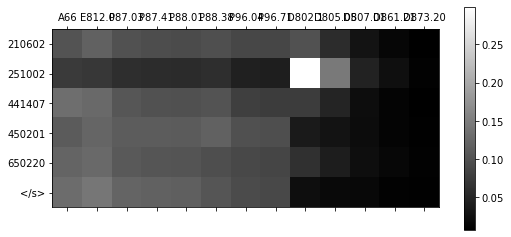

AIS_actual    210602 251002 441406 450201 650222
Name: 17, dtype: object


In [22]:
i=17
display_attn(attn_mat[i])
print(ais.iloc[i])

https://github.com/OpenNMT/OpenNMT-py/issues/897

I have tried -atten_debug. I found it is for global-attention between source words and target words, not for self-attention within source words.

http://nlp.seas.harvard.edu/2018/04/03/attention.html

80


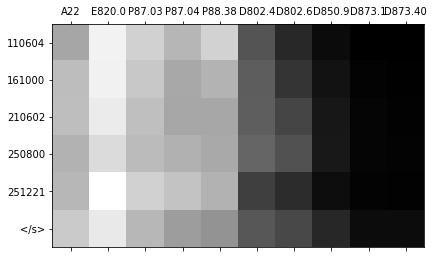

81


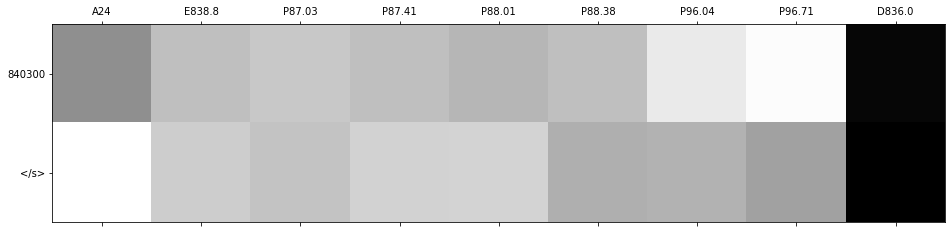

82


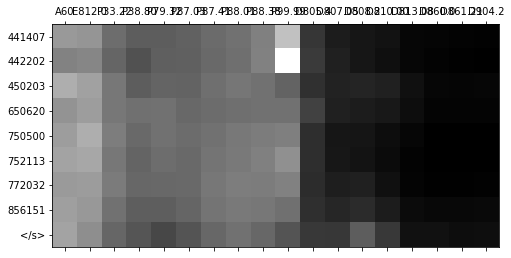

83


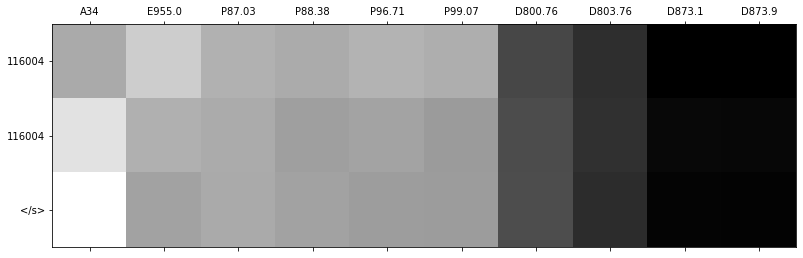

84


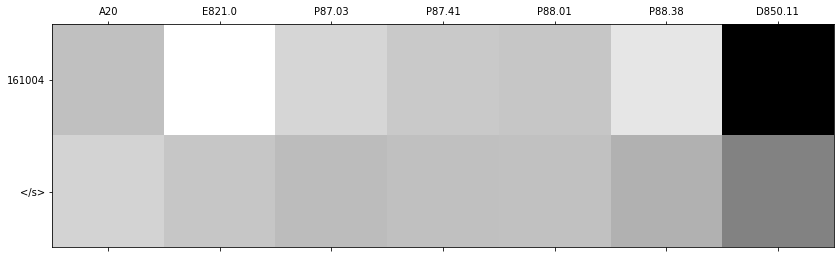

85


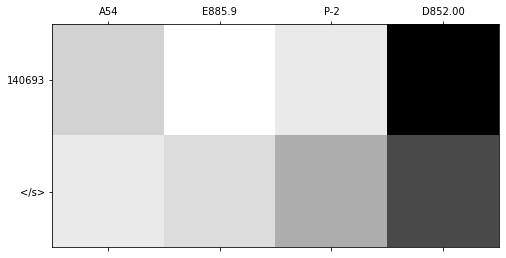

86


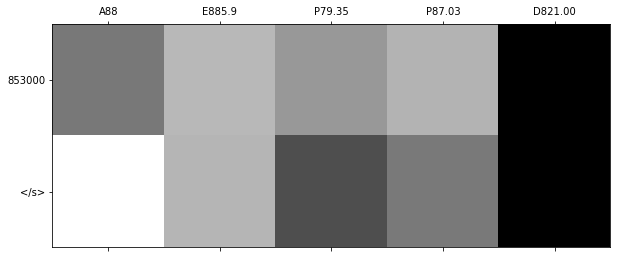

87


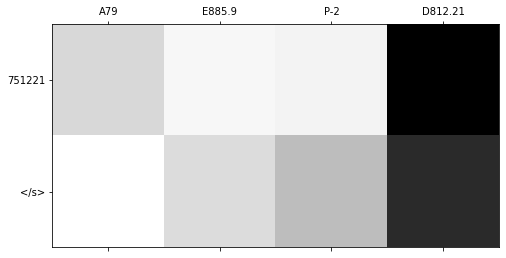

88


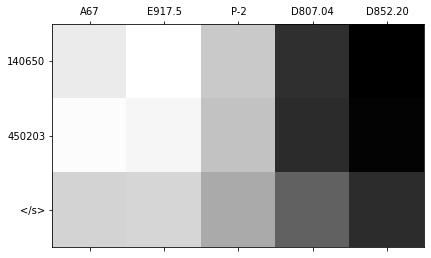

89


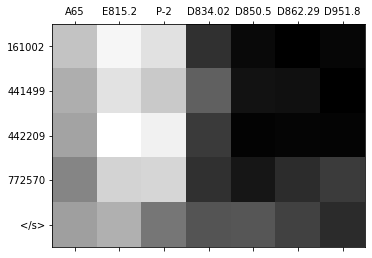

In [23]:
for i in range(80,90):
    print(i)
    display_attn(attn_mat[i], showmat=False, colorbar=False, d_only=False)